<a href="https://colab.research.google.com/github/yinghao1019/NLP_and_DL_practice/blob/master/Convolution_Neural_Netowrks_for_sentence_classification_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook is pytorch implementation for [Convolutional Neural Networks for Sentence Classification][id]**

### **Requirement**<br>
OS==Linux-Ubuntu18.04.05<br>python==3.6.9<br>


### **package<br>**
-pytorch==1.7.0+cu101<br>
-torchtext==0.3.1<br>
-spacy==2.2.4<br>

### **Data**<br>

|   | Train  | Dev  | Test | labels 
|:----: | :------: | ------: | ----- | ------: 
|IMDB  | 5678  | 2230  |265   | 2   |
|SST  | 1204  | 1230 |789    | 3   |
|SST   | 1204  | 1497 |365   | 5   |

-The numbers of label are based on Train set.


[id]:https://arxiv.org/abs/1408.5882


# **Prepare data**

In [2]:
import torch
from torch.nn import functional as F
from torch import nn,optim
from torch.optim.lr_scheduler import ExponentialLR,StepLR,MultiStepLR,LambdaLR,MultiplicativeLR,ReduceLROnPlateau
from torchtext import data,datasets

from sklearn import  metrics
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.svm import SVC

import random
import numpy as np
import spacy
import os
import time
SEED=1234


#set random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

#build Field and tokenizer
spacy.require_gpu()
en_nlp=spacy.load('en_core_web_sm')
def en_tokenizer(text):
  return [t.text for t in en_nlp.tokenizer(text) if t.text.isalpha()]
Text=data.Field(tokenize=en_tokenizer,lower=True,batch_first=True)
Target=data.Field(is_target=True,batch_first=True,pad_token=None,unk_token=None)
VOCAB_size=25001#set vocabuary size

#load data
train_data,test_data=datasets.IMDB.splits(Text,Target)
train_data,val_data=train_data.split(split_ratio=0.7,random_state=random.seed(SEED))
print('One examples:{} from IMDB'.format(train_data.examples[0]))

#build text Embedding vector
Text.build_vocab(train_data,vectors='glove.6B.100d',max_size=VOCAB_size)
Text.vocab.set_vectors(Text.vocab.stoi,Text.vocab.vectors,dim=100)

#build Target vocab
Target.build_vocab(train_data)

aclImdb_v1.tar.gz:   0%|          | 98.3k/84.1M [00:00<01:26, 976kB/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:12<00:00, 6.58MB/s]


One examples:<torchtext.data.example.Example object at 0x7f8eedd19278> from IMDB


.vector_cache/glove.6B.zip: 862MB [06:27, 2.22MB/s]                           
100%|█████████▉| 399589/400000 [00:30<00:00, 13502.00it/s]

In [3]:
#default Batch size is 50
Batch_size=256
device=torch.device('cuda:0')
train_iter=data.BucketIterator(train_data,batch_size=Batch_size,device=device,train=True,shuffle=True)
val_iter,test_iter=data.BucketIterator.splits((val_data,test_data),batch_size=Batch_size,device=device)

# **Build Model(2D CNN network)**<br>
===================
####**Embedding_layer**<br>
Pre-trained vector(GLoVe) or Rnd_init<br>
Input_dim=vocab_size<br>
embid_dim=100

===================
####**Convolution_layer**<br>
#####3 different filter to extract feature map from input_Embedding<br>
kernel_size=[3,Embed_dim],[4,Embed_dim],[5,Embed_dim]<br>

for each filter<br>
>N_channel=100<br>
>Pooling=Max_pooling.Size=FeatureMap_len<br>
>Activation=Tanh<br>

====================
####**fc_layer**<br>
Input_dim=3*channel_nums<br>
output_dim=label_nums

In [4]:
class ConvNets_2d(nn.Module):
  '''
  Class ConvNets_2d is a Neural network based on Convolution Layer.
  It's inherit from pytorch nn.Module class.So some class method is
  common.


  Architecture:
    1.Embedding_layer:This layer has three mode.One is using init Embed,
     another is using GLoVe pretrained Embed,the other is hybrid of
     GLoVe and init Embed.
    2.Convolution_layer:The three different type filter height is setting to 
     filter_size.And the filter width is fixed based on Embed dim.
     After filter,We choose ReLU for activations.For pooling strategy,
     we choose MaxPooling1D for each feature map.Finally,we concatenate
     Each feature into a single vector that genertaioned by pooling.
     
    3.Fully_connected_layer:
     This layer is output_layer.So it's shape will be 
     [n_filter*filter_size,output_dim].And it output is Logitics.


  Args:
    1.input_dim(int):This argument is used for setting Embedding input dim.
    2.embed_dim(int):This argument is used for setting Embedding dim.
    3.output_dim(int):This argument is used for whole netowrk output dim.
    4.n_filters(int):This argument is used for setting channel's num in each
     filter
    5.filter_size(list of int):This argument is set for different filter height.
     and use list to contain three filter height.
     e.g.[3,4,5].one filter'width will set three,another will set four.The other
           will set five.
    6.dropout_rate(float):This argument is used for setting final cocnated layer's
     dropout rate.
    7.pad_idx(int):This argument is used for setting index which Embed vector's is zero.
    8.pretrained_embed(torch tensor):This argument is used for loading pretrained Embedding 
     weight.Note that embed's vector nums is consistent with input_dim.
     if you don't set any torch tensor type embedding weight,it will use init random 
     Embedding layer.Default is None.
    9.is_mulc(boolean):This arguemnt is determined Whther is using Multi channel for Embed_layer.
  '''
  def __init__(self,input_dim,embed_dim,output_dim,n_filters,filter_size,
        dropout_rate,pad_idx=None,pretrained_embed=None,is_mulc=False):
    super(ConvNets_2d,self).__init__()

    #determined filter_size type and length
    assert isinstance(filter_size,tuple) and len(filter_size)==3,\
    'filter_size is not list type or len=3'
    #dteremined pretrained embed dtype and create
    if pretrained_embed is not None:
      assert isinstance(pretrained_embed,torch.tensor) and (pretrained_embed.shape[0]==input_dim),\
      "The pretrained Embed isn't a torch tensor type or nums don't equal to input_dim"

      self.is_pretrained=True
      if is_mulc:
        self.embed=nn.Embedding(input_dim,embed_dim,padding_idx=pad_idx)
        self.preEmbed=nn.Embedding.from_pretrained(pretrained_embed)
      else:
        self.preEmbed=nn.Embedding.from_pretrained(pretrained_embed)
    else:
      self.is_pretrained=False
      self.embed=nn.Embedding(input_dim,embed_dim,padding_idx=pad_idx)

    #set network main attr.
    self.input_dim=input_dim
    self.embed_dim=embed_dim
    self.output_dim=output_dim
    self.is_mulc=is_mulc
    self.inp_channels=2 if is_mulc else 1
    #create each filter height
    self.conv1=nn.Conv2d(self.inp_channels,n_filters,kernel_size=(filter_size[0],embed_dim))
    self.conv2=nn.Conv2d(self.inp_channels,n_filters,kernel_size=(filter_size[1],embed_dim))
    self.conv3=nn.Conv2d(self.inp_channels,n_filters,kernel_size=(filter_size[2],embed_dim))
    #build fc_layer
    self.fc_layer=nn.Linear(n_filters*len(filter_size),output_dim)

    self.ReLU=nn.ReLU()
    self.dropout=nn.Dropout(dropout_rate)

  def forward(self,input_tensors,using_ml=False):
    #determined whether to use multichannel Embedding or not.
    if self.is_mulc and self.is_pretrained:
      embed_output=self.embed(input_tensors).unsqueeze(1)
      pre_embed_output=self.preEmbed(input_tensors).unsqueeze(1)
      #embed_output=[bs,2,seqlen,embed_dim]
      embed_output=torch.cat((embed_output,pre_embed_output),dim=1)
    else:
      #embed_output=[bs,1,seqlen,embed_dim]
      embed_output=self.embed(input_tensors).unsqueeze(1)
    
    #feature_map=[bs,n_filters,map_len]
    fm_1=self.ReLU(self.conv1(embed_output).squeeze(3))
    fm_2=self.ReLU(self.conv2(embed_output).squeeze(3))
    fm_3=self.ReLU(self.conv3(embed_output).squeeze(3))

    #pooled=[bs,n_filters]
    pooled_1=F.max_pool1d(fm_1,fm_1.shape[2]).squeeze(2)
    pooled_2=F.max_pool1d(fm_2,fm_2.shape[2]).squeeze(2)
    pooled_3=F.max_pool1d(fm_3,fm_3.shape[2]).squeeze(2)

    #concat pooled=[bs,n_filters*3]
    cat_pool=torch.cat((pooled_1,pooled_2,pooled_3),dim=1)

    if using_ml:
      return cat_pool
    else:
      return self.fc_layer(cat_pool)

In [5]:
class Conv1d_LSTM(nn.Module):
  def __init__(self,input_embed,embed_dim,pad_idx,n_filters,output_hid,output_dim,
        filter_size,n_layers,dropout_rate=0.1,is_bidirectional=False):
    super(Conv1d_LSTM,self).__init__()
    #model attr.
    self.input_embed=input_embed
    self.embed_dim=embed_dim
    self.pad_idx=pad_idx
    self.output_dim=output_dim
    
    #build layer
    self.embedd_layer=nn.Embedding(input_embed,embed_dim,padding_idx=pad_idx)
    self.conv1d_embed=nn.Conv1d(embed_dim,n_filters,kernel_size=filter_size)
    self.rnn_layer=nn.LSTM(n_filters,output_hid,n_layers,batch_first=True,dropout=dropout_rate,bidirectional=is_bidirectional)
    self.fc_layer=nn.Linear(output_hid,int(output_hid/2))
    self.output_layer=nn.Linear(int(output_hid/2),output_dim)


    #build activFunc.
    self.tanh=nn.Tanh()
    self.ReLU=nn.ReLU()
    self.dropout_layer=nn.Dropout(dropout_rate)
  def forward(self,input_tensors):

    #tensor shape=[Bs,seqlen,embed_dim]
    embed_tensors=self.embedd_layer(input_tensors)
    #transpose and convert tensor from shape=[Bs,embed_dim,seqLen] into shape=[Bs,filter_num,pooled_seqLen]
    #In conv1d_layer,Each length(filter size) filter extract feature from embed_tensor to produce one feature map.
    #And we can view one feature map as one dim of embedding vector.So how many feature map,it's will be embedding dim.
    feature_maps=self.conv1d_embed(embed_tensors.transpose(1,2))

    #After Cnn Layer.we should transpose tensor to shape=[Bs,pooled_seqLen,filter_num]
    feature_maps=self.ReLU(feature_maps.transpose(1,2))

    #shape=[Bs,seqLen,output_hid]
    output_tensors,_=self.rnn_layer(feature_maps)

    #shape=[Bs,seqLen,output_hid/2]
    output_tensors=self.fc_layer(torch.mean(output_tensors,dim=1))
    
    #return logisitcs
    return self.output_layer(self.dropout_layer(self.ReLU(output_tensors)))

Set 
Evaluate Model func<br>
get Model Predict func<br>
Model Training pipeline func<br>
storage Model func<br>

In [6]:
def getModelPredict(outputs):
  preds=torch.where(F.sigmoid(outputs)>=0.5,1,0).squeeze(dim=1).cpu().detach().numpy()
  return preds
def getBClassEvaluate(pred_label,true_label):
  accuracy=metrics.accuracy_score(true_label,pred_label)
  f_score=metrics.f1_score(true_label,pred_label)
  return accuracy,f_score
def EvaluateModel(model,data_iter,loss_fn):
  total_loss=0
  total_accuracy=0
  total_F=0
  model.eval()
  with torch.no_grad():
    for bs in data_iter:
      input_texts=bs.text
      labels=bs.label

      #using autocast
      if torch.cuda.is_available():
        #output_logitics=[bs,num_labels]
        output_logitics=model(input_texts)
        loss=loss_fn(output_logitics,labels.float())
      
      total_loss+=loss.item()
      preds=getModelPredict(output_logitics)
      acc,f_score=getBClassEvaluate(preds,labels.cpu().detach().numpy())

      total_accuracy+=acc
      total_F+=f_score
  
  return {'loss':total_loss/len(data_iter),
      'Accuracy':total_accuracy/len(data_iter),
      'F_score':total_F/len(data_iter)}
def count_parameters(model):
  return sum(p.numel()for p in model.parameters() if p.requires_grad)
def trainModel(model,train_iter,optimizer,criterion,device):
  train_loss=0
  model.train()
  for bs in train_iter:
    if next(model.parameters()).is_cuda:
      input_texts=bs.text.to(device)
      labels=bs.label.to(device)
    else:
      input_texts=bs.text
      labels=bs.label
    
    #using autocast to choose appropriate datatype for each layer.
    output_logitics=model(input_texts)
    loss=criterion(output_logitics,labels.float())#compute loss
    train_loss+=loss.item()
    
    #scaled loss.And using backpropagation to compute scaled Gradient of corrspending dtype in forward pass stage.
    #This operation can avoid FP16 datatype can not present close zero problem
    loss.backward()

    #Fist step is unscaled gradient of optimizer assigned params.
    #if gradient value don't conatin NaN and inf,it will call optimizer.step()
    #other wise will skip optimizer.step()
    optimizer.step()
    optimizer.zero_grad()

  return train_loss/len(train_iter)

In [7]:
#Record Start training time
def epoch_trainModel(model,train_iter,val_iter,optimizer,criterion,n_epochs,device,scheduler=None,batch_size=None):
  total_time=0
  epoch_trainLoss=[]
  epoch_vaLoss=[]
  
  #modified Batch_size
  if batch_size is not None:
    train_iter.batch_size=batch_size
    val_iter.batch_size=Batch_size
  print(f'Current data Batch_size is {train_iter.batch_size}')
  for ep in range(n_epochs):
    #training Model
    start_time=time.time()
    train_loss=trainModel(model,train_iter,optimizer,criterion,device)
    end_time=time.time()

    #vaildate Model performance
    train_metrics=EvaluateModel(model,train_iter,criterion)
    eval_metrics=EvaluateModel(model,val_iter,criterion)

    #update learning rate
    if scheduler is not None:
      if isinstance(scheduler,ReduceLROnPlateau):
        scheduler.step(eval_metrics['loss'])
      else:
        print(f'{ep+1} epochs lr:{scheduler.get_lr()}\n')
        scheduler.step()
        
    #append train & val loss
    epoch_trainLoss.append(train_loss)
    epoch_vaLoss.append(eval_metrics['loss'])

    #display Model info.
    print(f'[{ep+1}/{N_epochs}] train_loss:{train_loss}')
    for key,v in train_metrics.items():
      if key!='loss':
        print(f'train {key}:{v}')
    for key,v in eval_metrics.items():
      print(f'eval {key}:{v}')
    total_time+=(end_time-start_time)
    print(f'Training time:{end_time-start_time}s \n')
  print(f'Total trainng time:{total_time}s')

  return epoch_trainLoss,epoch_vaLoss

For Training Pipeline

In [8]:
Input_dim=len(Text.vocab)
Embed_dim=100
Output_dim=1
n_filters=100
pad_idx=Text.vocab.stoi['<pad>']
filter_size=(3,4,5)
dropout_rate=0.5
N_epochs=13

model=ConvNets_2d(Input_dim,Embed_dim,Output_dim,n_filters,filter_size,dropout_rate,pad_idx=pad_idx)
model.to(device)
cnn_optim=optim.Adam(model.parameters())
criterion=nn.BCEWithLogitsLoss()
print('CovNets model scheme:{}'.format(model))
print(f'Model trainable parameters num:{count_parameters(model)}')

CovNets model scheme:ConvNets_2d(
  (embed): Embedding(25003, 100, padding_idx=1)
  (conv1): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
  (conv2): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
  (conv3): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  (fc_layer): Linear(in_features=300, out_features=1, bias=True)
  (ReLU): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)
Model trainable parameters num:2620901


In [ ]:
#Training model for original Batch size(50)
orig_trainLoss,orig_valLoss=epoch_trainModel(model,train_iter,val_iter,cnn_optim,criterion,N_epochs,device)

Current data Batch_size is 256


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|█████████▉| 399589/400000 [00:49<00:00, 13502.00it/s]

[1/13] train_loss:0.6483368692190751
train Accuracy:0.7961587310964083
train F_score:0.7807503622272323
eval loss:0.5357855419317882
eval Accuracy:0.7569969846491228
eval F_score:0.7421280518877117
Training time:15.49929141998291s 

[2/13] train_loss:0.45230969354726264
train Accuracy:0.864083668084436
train F_score:0.8638348947241846
eval loss:0.4386265506347021
eval Accuracy:0.8058662280701755
eval F_score:0.8093208914082817
Training time:15.470364332199097s 

[3/13] train_loss:0.35006855924924213
train Accuracy:0.9075127008506616
train F_score:0.91027772461839
eval loss:0.3955988178650538
eval Accuracy:0.8230811403508772
eval F_score:0.8340828447938884
Training time:15.359092712402344s 

[4/13] train_loss:0.26901468094708264
train Accuracy:0.9522044344675489
train F_score:0.9512724036481837
eval loss:0.35966992179552715
eval Accuracy:0.8428659539473685
eval F_score:0.8431240574991643
Training time:15.428332090377808s 

[5/13] train_loss:0.19979574909244757
train Accuracy:0.975592706

In [ ]:
#build Cnn-lstm Model to compare
Lstm_n_filters=256
output_hid=128
Lstm_filter_size=3
n_layers=2
cnnLstm_model=Conv1d_LSTM(Input_dim,Embed_dim,pad_idx,Lstm_n_filters,output_hid,Output_dim,Lstm_filter_size,n_layers)
cnnLstm_model.to(device)
Lstm_optim=optim.Adam(cnnLstm_model.parameters())
print('cnn-lstm model scheme:{}'.format(cnnLstm_model))
print(f'Model trainable parameters num:{count_parameters(cnnLstm_model)}')

cnn-lstm model scheme:Conv1d_LSTM(
  (embedd_layer): Embedding(25003, 100, padding_idx=1)
  (conv1d_embed): Conv1d(100, 256, kernel_size=(3,), stride=(1,))
  (rnn_layer): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.1)
  (fc_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (tanh): Tanh()
  (ReLU): ReLU()
  (dropout_layer): Dropout(p=0.1, inplace=False)
)
Model trainable parameters num:2915405


In [ ]:
#trainng Cnn1D_lstm
lstm_trainLoss,lstm_valLoss=epoch_trainModel(cnnLstm_model,train_iter,val_iter,Lstm_optim,criterion,N_epochs,device)

Current data Batch_size is 256


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1/13] train_loss:0.669825585855954
train Accuracy:0.6796973456206679
train F_score:0.5856240142053458
eval loss:0.629696786403656
eval Accuracy:0.6568736293859648
eval F_score:0.5634935999579983
Training time:31.563514947891235s 

[2/13] train_loss:0.5237360864445784
train Accuracy:0.8163127166036547
train F_score:0.8065429055185189
eval loss:0.4839313060045242
eval Accuracy:0.7796737938596491
eval F_score:0.7688248288819864
Training time:31.066923141479492s 

[3/13] train_loss:0.43420940119287244
train Accuracy:0.8426645203213611
train F_score:0.8250218973408602
eval loss:0.46212742626667025
eval Accuracy:0.7961896929824561
eval F_score:0.7758636937635645
Training time:31.12393045425415s 

[4/13] train_loss:0.3331056561159051
train Accuracy:0.89966081836799
train F_score:0.899282009031564
eval loss:0.38027555247147876
eval Accuracy:0.8415775767543859
eval F_score:0.8437938211734203
Training time:30.90000891685486s 

[5/13] train_loss:0.2687930335169253
train Accuracy:0.92055814823566

###**OTHER MODEL Type**

In [ ]:
#build Random Forest Model
class HybridMDL_model:
  def __init__(self,ML_model,DL_model,ml_kwargs,device):
    #build Model
    self.ml_model=ML_model(**ml_kwargs)
    self.DL_model=DL_model
    assert isinstance(self.DL_model,nn.Module)

    self.ml_kwargs=ml_kwargs
    self.device=device
  def online_train(self,input_iters):
    #extract feature using dl_model

    self.DL_model.eval()
    with torch.no_grad():
      for bs in input_iters:
        if next(self.DL_model.parameters()).is_cuda:
          input_texts=bs.text.to(self.device)
          labels=bs.label.to(self.device).squeeze(dim=1)
        else:
          input_texts=bs.text
          labels=bs.label.squeeze(dim=1)
        #x_logitics shape=[bs,feature_dim]
        x_logitics=self.DL_model(input_texts,using_ml=True)
        #convert to numpy array
        x_logitics=x_logitics.cpu().clone().numpy()
        #online training ML_model
        self.ml_model.fit(x_logitics,labels.cpu().clone().numpy())
      
      #evaluate hybrid Model
      acc=self.evaluate_model(train_iter)
      print(f'Hybrid Model Training Accuracy:{acc}')
  def evaluate_model(self,val_iter):
    total_accuracy=0
    self.DL_model.eval()
    with torch.no_grad():
      for bs in val_iter:
        if next(self.DL_model.parameters()).is_cuda:
          input_texts=bs.text.to(self.device)
          labels=bs.label.to(self.device).squeeze(dim=1)
        else:
          input_texts=bs.text
          labels=bs.label.squeeze(dim=1)
        #x_logitics shape=[bs,feature_dim]
        x_logitics=self.DL_model(input_texts,using_ml=True)
        #convert to numpy array
        x_logitics=x_logitics.cpu().clone().numpy()
        #online training ML_model
        accuracy=self.ml_model.score(x_logitics,labels.cpu().clone().numpy())
        total_accuracy+=accuracy
    
    return total_accuracy/len(val_iter)
  def predict(self,input_tensors):
    x_logitics=self.DL_model(input_tensors,using_ml=True)
    x_logitics=x_logitics.cpu().clone().detach().numpy()

    #model_predict
    predicts=self.ml_model.predict(x_logitics)
    return predicts

In [ ]:
# #build Random forest and CNN2d hybrid Model
# Rf_params={'n_estimators':145,'max_depth':5,'n_jobs':-1,'warm_start':True}
# RF_cnn2d=HybridMDL_model(RandomForestClassifier,model,Rf_params,device)

# #training Model
# RF_cnn2d.online_train(train_iter)
# print(f'val_accuracy:{RF_cnn2d.evaluate_model(val_iter)}')
# print(f'test accuracy:{RF_cnn2d.evaluate_model(test_iter)}')

# **Inference stage**
In inference stage,we can use trained model to predict input sentences sentiment.<br>
**Note**:if we input sentence length less than filter window size.model will be not work.So we set min_length argument.if sent_length<min_len,we pad sent that length equal to min_length argument.

In [ ]:
def predict_sentiment(model,input_sents,Field,min_length):
  if isinstance(input_sents,str):
    input_tokens=[t.text.lower() for t in en_nlp.tokenizer(input_sents) if t.text.isalpha()]
  else:
    input_tokens=[t.lower() for t in input_sents if t.isalpha()]
  
  #pad_tokens
  if len(input_tokens)<min_length:
    input_tokens+=['<pad>']*(min_length-len(input_tokens))
  
  #convert to tensor
  input_tensor=Field.numericalize([input_tokens])

  if isinstance(model,nn.Module):
    if next(model.parameters()).is_cuda:
      input_tensor=input_tensor.cuda()
      output_logitics=model(input_tensor)
      predict=getModelPredict(output_logitics)
    return predict[0]
  else:
    if next(model.DL_model.parameters()).is_cuda:
      input_tensor=input_tensor.cuda()

      return model.predict(input_tensor)
  

In [ ]:
test_example=test_data.examples[0]
test_sent=test_example.text
sentiment_score=predict_sentiment(model,test_sent,Text,5)
# hybrid_sentiment=predict_sentiment(RF_cnn2d,test_sent,Text,5)
print('-'*10+'Model predict'+'-'*10)
print(f"Test_text:{' '.join(test_sent)}\n sentiment:{Target.vocab.itos[sentiment_score]}")
print('-'*10+'Hybrid Model predict'+'-'*10)
# print(f"Test_text:{' '.join(test_sent)}\n sentiment:{Target.vocab.itos[hybrid_sentiment[0]]}")

----------Model predict----------
Test_text:a genuinely creepy ghost story full of chills and sensuality this movie just falls short of what it promises it is apparently based on an old ghost story and perhaps relies a little too much on a simple premise for most of the way its imaginative and genuinely gripping but at the end its almost like oshima just lost interest in it and brought it to a rapid story is simple a woman and her younger lover kill her husband so that they can be together but their failure of nerve and his returning ghost condemn them to madness its beautifully handled with imaginative set scenes and the lovers passion is portrayed beautifully but too often the movie fails to really deliver on its promise almost as if oshima loses his nerve in the same way the lovers a worthwhile movie to watch just to see how oshima combines his great skill as a film maker with some exploitation movie tricks to pull the audience along but sadly its not a true classic in the mold of m

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


#**Expirement Stage**
We use other hyperparameter Strategy for experiment Model performance.<br>
&nbsp;

####It's contain:<br>
 1.MiniBatch Size(128,256,512,1024)<br>
 2.Learning Rate and Learning Rate schedule<br>
 3.different type optimizer(SGD,RMSprop,Adgrad,Adam)<br>
 4.Warm-up and linear scaling rule

In [ ]:
#display model loss time trend
import matplotlib.pyplot as plt
from math import ceil
# def autoLabel(line_2ds,ax):
#   xy_data=line_2ds[0].get_xydata()
#   for idx in range(xy_data.shape[0]):
#     ax.annotate(
#         '{:.3f}'.format(xy_data[idx,1]),xy=(xy_data[idx,0],xy_data[idx,1]),
#         xytext=(0,4),textcoords='offset points',ha='center',va='bottom')
  
def plot_Loss(times,times_loss,markers,colors,labels,titles):
  rows=ceil(len(time_loss[0])/1)
  fig=plt.figure(figsize=(10,8))
  

  #plot lines
  for idx in range(0,rows):
    ax=fig.add_subplot(rows,1,idx+1)
    for tl,m,c,l in zip(times_loss,markers,colors,labels):
      line2ds=ax.plot(times,tl[idx],color=c,label=l,marker=m,ms=1.3)

      ax.set_xticks(times)
      ax.set_xticklabels(times)
      ax.set_xlabel('Epochs')
      ax.set_ylabel('Loss')
      ax.set_title(titles[idx])
      ax.legend()
  fig.tight_layout()
  plt.show()

In [ ]:

#training model with different Batch_size
optim_loss={}
Bs_params={'Bs_128':128,'Bs_256':256,'Bs_512':512,'Bs_1024':1024}
for names in Bs_params.keys():
  model=ConvNets_2d(Input_dim,Embed_dim,Output_dim,n_filters,filter_size,dropout_rate,pad_idx=Text.vocab.stoi['<pad>'])
  model.to(device)
  optimizer=optim.Adam(model.parameters())
  train_loss,val_loss=epoch_trainModel(model,train_iter,val_iter,optimizer,criterion,N_epochs,device,batch_size=Bs_params[names])
  optim_loss[names]=(train_loss,val_loss)
optim_loss['Bs_50']=(orig_trainLoss,orig_valLoss)

Current data Batch_size is 128


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1/13] train_loss:0.5546679116078537
train Accuracy:0.8498467748333862
train F_score:0.8415179825046464
eval loss:0.4515999595324198
eval Accuracy:0.7976014254385965
eval F_score:0.7910763945103184
Training time:15.326228380203247s 

[2/13] train_loss:0.3540203961795264
train Accuracy:0.9299304784195493
train F_score:0.9299367332829213
eval loss:0.3695418894290924
eval Accuracy:0.8391378837719298
eval F_score:0.8445372153113312
Training time:15.376972198486328s 

[3/13] train_loss:0.24449862169958378
train Accuracy:0.9689334735004761
train F_score:0.9680739552490187
eval loss:0.33911925653616587
eval Accuracy:0.8535567434210526
eval F_score:0.8522989990429913
Training time:15.291213750839233s 

[4/13] train_loss:0.15429192884777584
train Accuracy:0.9904767335766423
train F_score:0.9901921110941281
eval loss:0.3305753941337268
eval Accuracy:0.8533785635964912
eval F_score:0.8507465919176849
Training time:15.329246282577515s 

[5/13] train_loss:0.0935222997065008
train Accuracy:0.9978107

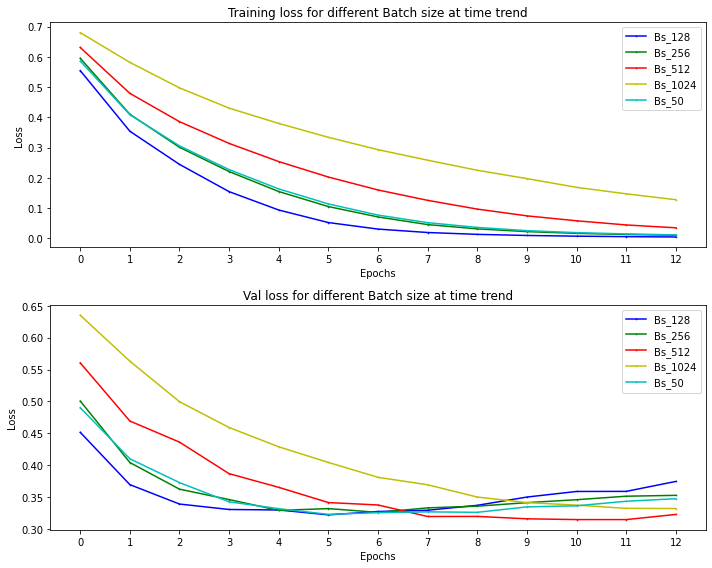

In [ ]:
x_times=range(0,N_epochs)
titles=['Training loss for different Batch size at time trend','Val loss for different Batch size at time trend']

labels=list(optim_loss.keys())
time_loss=list(optim_loss.values())
colors=['b','g','r','y','c']
markers=['.']*len(time_loss)
plot_Loss(x_times,time_loss,markers,colors,labels,titles)

In [ ]:
#training model with different optimizer,and we set 1e-2 for each optimizer learning rate.
Batch_size=256
optim_loss={}
optim_params={'SGD':optim.SGD,'RMSprop':optim.RMSprop,'Adagrad':optim.Adagrad,'Adam':optim.Adam}
for names in optim_params.keys():
  model=ConvNets_2d(Input_dim,Embed_dim,Output_dim,n_filters,filter_size,dropout_rate,pad_idx=Text.vocab.stoi['<pad>'])
  model.to(device)
  optimizer=optim_params[names](model.parameters(),lr=1e-2)
  train_loss,val_loss=epoch_trainModel(model,train_iter,val_iter,optimizer,criterion,N_epochs,device,batch_size=Batch_size)
  optim_loss[names]=(train_loss,val_loss)

Current data Batch_size is 256


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1/13] train_loss:0.7027003048122793
train Accuracy:0.5165431041272842
train F_score:0.6587244133354734
eval loss:0.6914649387200673
eval Accuracy:0.52109375
eval F_score:0.6652822068052352
Training time:15.069143533706665s 

[2/13] train_loss:0.6921034057935079
train Accuracy:0.550249586483932
train F_score:0.6636166183843086
eval loss:0.6845425844192505
eval Accuracy:0.547717927631579
eval F_score:0.6666430964747195
Training time:15.254122257232666s 

[3/13] train_loss:0.6952179048372351
train Accuracy:0.5056735389098929
train F_score:0.013392160707098005
eval loss:0.7063638170560201
eval Accuracy:0.49462719298245617
eval F_score:0.013954662362527773
Training time:15.042751789093018s 

[4/13] train_loss:0.6889220873514811
train Accuracy:0.6304766264965344
train F_score:0.669935362349184
eval loss:0.6724340756734212
eval Accuracy:0.6094572368421053
eval F_score:0.6608717678424088
Training time:15.211666107177734s 

[5/13] train_loss:0.6769154305043428
train Accuracy:0.5052206403591682

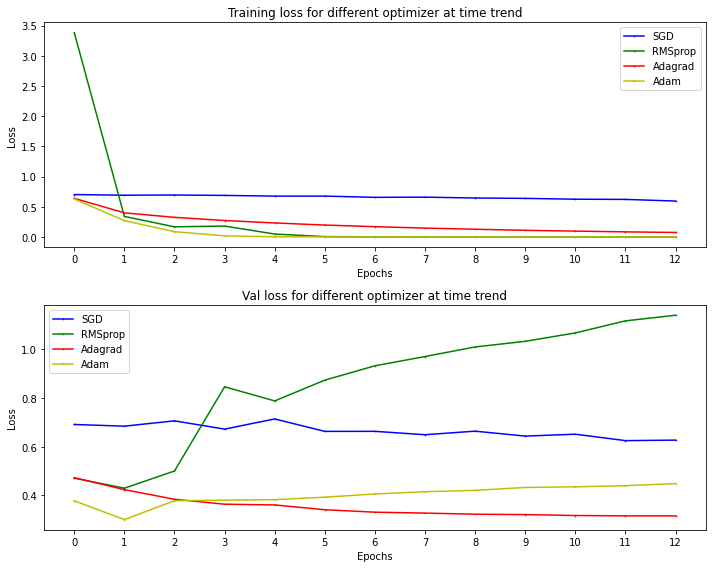

In [ ]:
#plot training and val
labels=list(optim_loss.keys())
time_loss=list(optim_loss.values())
colors=['b','g','r','y']
titles=['Training loss for different optimizer at time trend','Val loss for different optimizer at time trend']
markers=['.']*len(time_loss)
plot_Loss(x_times,time_loss,markers,colors,labels,titles)

In [ ]:
#training model with different learning rate.
Batch_size=256
optim_loss={}
lr_params={'lr_1e-1':1e-1,'lr_1e-2':1e-2,'lr_1e-3':1e-3,'lr_1e-4':1e-4,'lr_1e-5':1e-5}

for names in lr_params.keys():
  #build Model
  model=ConvNets_2d(Input_dim,Embed_dim,Output_dim,n_filters,filter_size,dropout_rate,pad_idx=Text.vocab.stoi['<pad>'])
  model.to(device)
  optimizer=optim.Adam(model.parameters(),lr=lr_params[names])

  #collect Model info
  train_loss,val_loss=epoch_trainModel(model,train_iter,val_iter,optimizer,criterion,N_epochs,device,batch_size=Batch_size)
  optim_loss[names]=(train_loss,val_loss)



Current data Batch_size is 256


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1/13] train_loss:4.858122835124749
train Accuracy:0.5305165012602394
train F_score:0.31676626708600897
eval loss:1.0308108667532603
eval Accuracy:0.5111430921052631
eval F_score:0.3027262400193059
Training time:15.065077543258667s 

[2/13] train_loss:1.0362241708714028
train Accuracy:0.6008290012602394
train F_score:0.4405155774807874
eval loss:1.2002953231334685
eval Accuracy:0.5447025767543859
eval F_score:0.3496175113088327
Training time:15.017772436141968s 

[3/13] train_loss:1.12863065108009
train Accuracy:0.7076293714555766
train F_score:0.7380410467328123
eval loss:2.209284253915151
eval Accuracy:0.5898368969298246
eval F_score:0.6450865138629047
Training time:15.110283136367798s 

[4/13] train_loss:1.6679056822389797
train Accuracy:0.6679367517328293
train F_score:0.5368363579393559
eval loss:3.250558412075043
eval Accuracy:0.5717105263157894
eval F_score:0.40380020503689085
Training time:14.806352138519287s 

[5/13] train_loss:2.740209598472153
train Accuracy:0.62883979206049

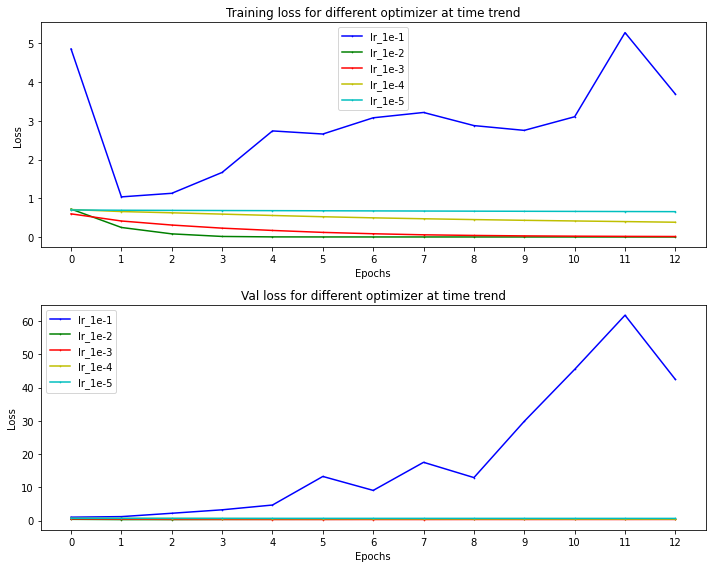

In [ ]:
#plot training and val
labels=list(optim_loss.keys())
time_loss=list(optim_loss.values())
colors=['b','g','r','y','c']
markers=['.']*len(time_loss)
plot_Loss(x_times,time_loss,markers,colors,labels,titles)

In [ ]:
#using different type learning Rate scheduler to train Model
#define linear decay func
linear_lambda=lambda epoch:(N_epochs-epoch)/N_epochs
optim_loss={}
lr_params={'exp_decay':(ExponentialLR,{'gamma':0.85}),'step_deacy(3)':(StepLR,{'step_size':3,'gamma':0.5}),'Linear_Decay':(LambdaLR,{'lr_lambda':linear_lambda}),
      'Muti_step':(MultiStepLR,{'milestones':[3,5]+list(range(7,9))}),'ReduceLOP':(ReduceLROnPlateau,{'mode':'min','factor':0.5,'patience':4})}

for names in lr_params.keys():
  #build Model
  model=ConvNets_2d(Input_dim,Embed_dim,Output_dim,n_filters,filter_size,
           dropout_rate,pad_idx=Text.vocab.stoi['<pad>'])
  model.to(device)
  optimizer=optim.SGD(model.parameters(),lr=75e-3,momentum=0.9,dampening=5e-1)
  scheduler=lr_params[names][0](optimizer,**lr_params[names][1])

  #collect Model info
  train_loss,val_loss=epoch_trainModel(model,train_iter,val_iter,optimizer,criterion,
                    N_epochs,device,scheduler=scheduler,batch_size=Batch_size)
  optim_loss[names]=(train_loss,val_loss)

Current data Batch_size is 256


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:449: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


1 epochs lr:[0.075]

[1/13] train_loss:2.319320908491162
train Accuracy:0.698128347511027
train F_score:0.6901878870936052
eval loss:0.6440131008625031
eval Accuracy:0.655187774122807
eval F_score:0.6502772704129367
Training time:15.340419054031372s 

2 epochs lr:[0.0541875]

[2/13] train_loss:0.5478207071622213
train Accuracy:0.8296166115311909
train F_score:0.8321368423909945
eval loss:0.46605655749638875
eval Accuracy:0.780139802631579
eval F_score:0.7883037975458934
Training time:15.04235053062439s 

3 epochs lr:[0.046059375]

[3/13] train_loss:0.3866319665010425
train Accuracy:0.9069834987397606
train F_score:0.9056051148265496
eval loss:0.39779412349065146
eval Accuracy:0.8159265350877193
eval F_score:0.8169196498613764
Training time:15.153416633605957s 

4 epochs lr:[0.03915046875]

[4/13] train_loss:0.26637744212496106
train Accuracy:0.9639748739760555
train F_score:0.963505489983142
eval loss:0.3814112454652786
eval Accuracy:0.8261855811403509
eval F_score:0.8280366339480728
T

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


1 epochs lr:[0.075]

[1/13] train_loss:1.4591568898463594
train Accuracy:0.7782569313169502
train F_score:0.7714181387197261
eval loss:0.5290778448184331
eval Accuracy:0.7454906798245614
eval F_score:0.7427926624491362
Training time:15.59662675857544s 

2 epochs lr:[0.075]

[2/13] train_loss:0.4372132722882257
train Accuracy:0.7736221053875236
train F_score:0.8133092121847001
eval loss:0.5710230131944021
eval Accuracy:0.7254865679824561
eval F_score:0.7829708687029788
Training time:15.613274574279785s 

3 epochs lr:[0.075]

[3/13] train_loss:0.271751474859058
train Accuracy:0.9765871140516699
train F_score:0.9764026356054749
eval loss:0.368778928120931
eval Accuracy:0.8330523574561404
eval F_score:0.8368606615810366
Training time:15.391385555267334s 

4 epochs lr:[0.01875]

[4/13] train_loss:0.12762587074784265
train Accuracy:0.9971127717391305
train F_score:0.9970674555153104
eval loss:0.3680331806341807
eval Accuracy:0.8363075657894737
eval F_score:0.842184225726422
Training time:15.

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


1 epochs lr:[0.075]

[1/13] train_loss:1.2910162901532822
train Accuracy:0.7800488342785129
train F_score:0.8013876202211373
eval loss:0.5240250011285146
eval Accuracy:0.7440652412280702
eval F_score:0.7760452266163629
Training time:15.241688251495361s 

2 epochs lr:[0.06923076923076923]

[2/13] train_loss:0.45143716490787006
train Accuracy:0.9130287098298676
train F_score:0.9148465411669113
eval loss:0.3959175646305084
eval Accuracy:0.8259868421052631
eval F_score:0.8343644568852754
Training time:15.298599004745483s 

3 epochs lr:[0.06346153846153846]

[3/13] train_loss:0.2648459167584129
train Accuracy:0.9757256222432262
train F_score:0.9753827530994833
eval loss:0.3779036611318588
eval Accuracy:0.8311472039473684
eval F_score:0.8329782990709688
Training time:15.288048505783081s 

4 epochs lr:[0.057692307692307696]

[4/13] train_loss:0.1328387037999388
train Accuracy:0.9937283396345306
train F_score:0.9936391846231947
eval loss:0.40229145089785256
eval Accuracy:0.8258086622807018
eva

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


1 epochs lr:[0.075]

[1/13] train_loss:1.3714293129202249
train Accuracy:0.7746140516698172
train F_score:0.7493918850768772
eval loss:0.5377231121063233
eval Accuracy:0.730407072368421
eval F_score:0.7006921172542319
Training time:15.344858884811401s 

2 epochs lr:[0.075]

[2/13] train_loss:0.4401677596396294
train Accuracy:0.9097255040957782
train F_score:0.904816169380586
eval loss:0.417764350771904
eval Accuracy:0.8052700109649124
eval F_score:0.7955259220918446
Training time:15.203778505325317s 

3 epochs lr:[0.075]

[3/13] train_loss:0.24987279461777728
train Accuracy:0.978580852236925
train F_score:0.9784837692040224
eval loss:0.3754892726739248
eval Accuracy:0.8305098684210527
eval F_score:0.8359363652343444
Training time:15.351830959320068s 

4 epochs lr:[0.00075]

[4/13] train_loss:0.11375162653301073
train Accuracy:0.9890861294896031
train F_score:0.9888702243695541
eval loss:0.3770532647768656
eval Accuracy:0.8324355811403509
eval F_score:0.835271744332244
Training time:15.

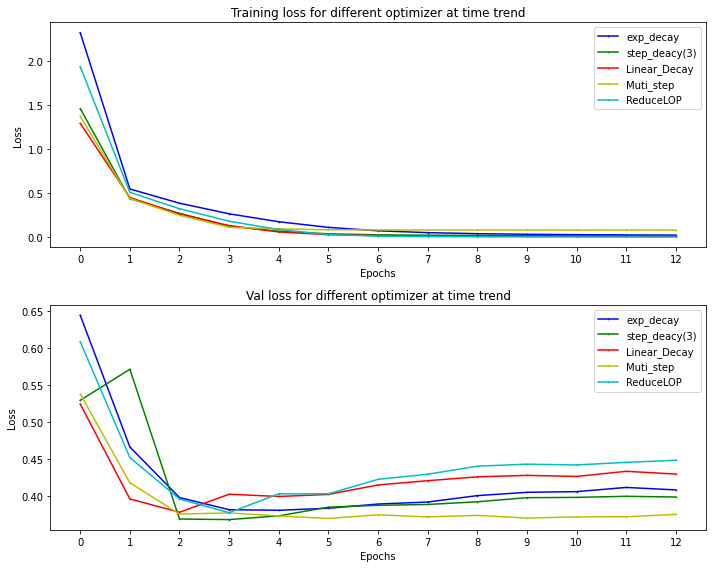

In [ ]:
#plot training and val
labels=list(optim_loss.keys())
time_loss=list(optim_loss.values())
colors=['b','g','r','y','c']
markers=['.']*len(time_loss)
plot_Loss(x_times,time_loss,markers,colors,labels,titles)

In [ ]:
#

##Other Model arcticture<br>
1.採用1D Cnn
2.使用character-level Cnn
3.使用CNN-LSTM
4.採用Warm up schedule Method
5.downstream改接ML_model